# Ejercicio Graph Isomorphism Network (GIN)

# Caso real: Citations

Probaremos la red en un dataset real con una tarea real, prediccion de la categoria de un paper segun la red de citas.

* Los nodos son articulos
* Las aristas son citas entre articulos
* Los atributos de los nodos representan el texto del articulo.
* Predecir una categoria de entre 7 posibles

Mensaje: identidad, z
Agregacion: suma
update: MLP (un parametro), (i+...) (segundo parametro) y lo que resulta de la agregacion (es agg_out)

todo lo que dependa de zv, tiene que ser la agregacion: lo que afecta al mensaje (la suma)
v son vecinos de u, vienen de la capa anterior.

u es el nodo actual


---

En el contexto de las **Redes Neuronales de Grafos (GNNs)**, la ecuación:

$$
z_u^l = \text{MLP}_{\theta}^l \left( \left( 1 + \epsilon^l \right) \odot z_u^{l-1} + \sum_{v \in \mathcal{N}(u)} z_v^{l-1} \right)
$$

representa cómo un nodo \( u \) actualiza su representación en la capa \( l \). Esta ecuación describe tres componentes clave: **mensaje**, **agregación** y **actualización**. Vamos a desglosarlos:

---

#### 1. Mensaje

El **mensaje** es la información que un nodo \( u \) recibe de sus vecinos. En este caso, el mensaje que recibe el nodo \( u \) está dado por las representaciones de los vecinos \( v \), es decir:

$$
\text{Mensaje} = z_v^{l-1}, \quad \forall v \in \mathcal{N}(u)
$$

Este mensaje se usa para influir en la nueva representación del nodo \( u \).

---

#### 2. Agregación

La **agregación** es el proceso de combinar los mensajes recibidos de todos los vecinos de un nodo. En este caso, se realiza una **suma** de las representaciones \( z_v\) de los vecinos \( v \) de \( u \), es decir:

$$
\text{Agregación} = \sum_{v \in \mathcal{N}(u)} z_v^{l-1}
$$

Este paso permite que el nodo \( u \) capture la información global de su vecindad, lo cual es fundamental para actualizar su representación.

---

#### 3. Actualización

La **actualización** de la representación de \( u \) se realiza después de combinar su propia representación ajustada con la agregación de los mensajes de sus vecinos. La ecuación completa de actualización es:

$$
z_u^l = \text{MLP}_{\theta}^l \left( \left( 1 + \epsilon^l \right) \odot z_u^{l-1} + \sum_{v \in \mathcal{N}(u)} z_v^{l-1} \right)
$$

- El nodo \( u \) ajusta su propia representación en la capa anterior, multiplicándola por (1 + \epsilon), lo cual puede ser un parámetro de regularización o influencia.
- La información combinada de su propio estado ajustado y la agregación de los mensajes de los vecinos se pasa a través de una **MLP** (Perceptrón Multicapa) para obtener la nueva representación \( z_u^l \).



In [1]:
!pip install torch-geometric --quiet

In [2]:
!pip install torch torchvision torchaudio --quiet

## Cargar dataset

In [3]:
from torch_geometric.datasets import CitationFull

dataset = CitationFull(root='CitationFull', name='Cora_ML')
print(f"Number of graphs: {len(dataset)}")

data = dataset[0]
print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Number of graphs: 1
Attributes: ['x', 'edge_index', 'y']
Number of nodes: 2995
Number of edges: 16316
Number of node features: 2879
Number of edge features: 0
Number of classes: 7
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Definir una capa nueva de paso de mensajes

$$
z_u^l = \text{MLP}_{\theta}^l \left( \left( 1 + \epsilon^l \right) \odot z_u^{l-1} + \sum_{v \in \mathcal{N}(u)} z_v^{l-1} \right)
$$

In [34]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import  MLP

class GIN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GIN, self).__init__(aggr='sum')  # Agregación por suma
        # MLP para aprender la transformación de características
        self.mlp = MLP(
            in_channels=in_channels,
            out_channels=out_channels,
            hidden_channels=32,  # Número de neuronas en la capa oculta
            num_layers=2,  # Número de capas en el MLP
            act=torch.nn.ReLU()
        )
        # Parámetro epsilon que se aprende
        self.epsilon = Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.reset_parameters()

    def reset_parameters(self):
        #self.mlp.reset_parameters()
        self.epsilon.data.fill_(0.5)  # Inicialización de epsilon a 0.5

    def forward(self, x, edge_index):
        # Pasamos x como nodo central para usarlo en `update`
        return self.propagate(edge_index, x=x, central_node=x)

    def message(self, x_j):
        return x_j  # Mensaje es simplemente la información de los vecinos

    def update(self, aggr_out, central_node):
        # Aplicar la fórmula descrita
        out = (1 + self.epsilon) * central_node + aggr_out
        return self.mlp(out)  # Aplicar MLP después de sumar

In [35]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import  MLP

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GIN(node_features, hidden_channels)
        self.conv2 = GIN(hidden_channels, hidden_channels)
        self.cls = MLP(
            in_channels=hidden_channels,  # Cambiar a `hidden_channels`
            out_channels=num_classes, 
            num_layers=2, 
            hidden_channels=hidden_channels, 
            act='relu',
            dropout=0.5
        )

    def forward(self, x, edge_index):
        # Entrada
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        # Segunda capa GIN
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        # Clasificación final
        x = self.cls(x)
        return x

## Cargar dataset

In [36]:
from torch_geometric.datasets import CitationFull

dataset = CitationFull(root='CitationFull', name='Cora_ML')
print(f"Number of graphs: {len(dataset)}")

data = dataset[0]
print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Number of graphs: 1
Attributes: ['x', 'edge_index', 'y']
Number of nodes: 2995
Number of edges: 16316
Number of node features: 2879
Number of edge features: 0
Number of classes: 7
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Dividir dataset

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(data.num_nodes), test_size=0.2, stratify=data.y)

train_mask = np.zeros(data.num_nodes, dtype=bool)
train_mask[train_idx] = True

test_mask = np.zeros(data.num_nodes, dtype=bool)
test_mask[test_idx] = True

data.train_mask = torch.tensor(train_mask)
data.test_mask = torch.tensor(test_mask)

## Train

In [8]:
!pip install torchmetrics --quiet

In [38]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchmetrics.classification import MulticlassF1Score

# Definir el modelo
model = GCN(node_features=dataset.num_node_features, hidden_channels=16, num_classes=dataset.num_classes)

# Definir optimizador, función de pérdida y métrica
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = CrossEntropyLoss()
metric = MulticlassF1Score(num_classes=dataset.num_classes)

# Entrenamiento
model.train()
for epoch in range(300):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)  # Predicciones
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Pérdida
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        pred = out.argmax(dim=1)
        f1 = metric(pred[data.test_mask], data.y[data.test_mask])
        print(f"Epoch {epoch}: Loss {loss.item()}, F1 Score {f1}")
        model.train()

Epoch 0: Loss 2.0862016677856445, F1 Score 0.1143273115158081
Epoch 10: Loss 1.6358572244644165, F1 Score 0.3023878037929535
Epoch 20: Loss 1.376190185546875, F1 Score 0.3788899779319763
Epoch 30: Loss 1.183387279510498, F1 Score 0.445170521736145
Epoch 40: Loss 1.0359878540039062, F1 Score 0.4524482190608978
Epoch 50: Loss 0.9492319226264954, F1 Score 0.5514733195304871
Epoch 60: Loss 0.8385825157165527, F1 Score 0.5256386995315552
Epoch 70: Loss 0.8142930865287781, F1 Score 0.5784188508987427
Epoch 80: Loss 0.7741685509681702, F1 Score 0.5620482563972473
Epoch 90: Loss 0.7533338665962219, F1 Score 0.5773921608924866
Epoch 100: Loss 0.7382384538650513, F1 Score 0.5742613673210144
Epoch 110: Loss 0.6986967921257019, F1 Score 0.5605551600456238
Epoch 120: Loss 0.6517176032066345, F1 Score 0.6001763343811035
Epoch 130: Loss 0.6610400080680847, F1 Score 0.6024633646011353
Epoch 140: Loss 0.6493600606918335, F1 Score 0.5849583745002747
Epoch 150: Loss 0.6368087530136108, F1 Score 0.6028776

## Test model

F1 score: 0.7095158597662772


<Axes: >

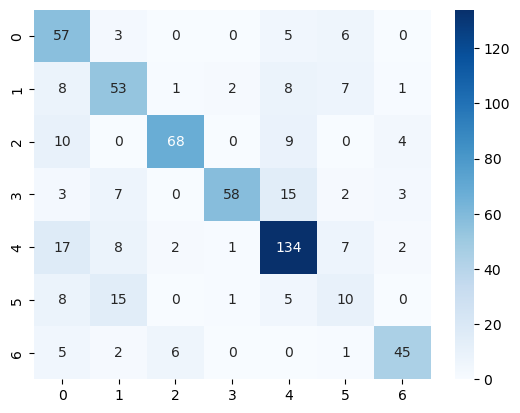

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model.eval()
y_pred = out.argmax(dim=1)[data.test_mask].detach().cpu()
y = data.y[data.test_mask].detach().cpu()

print(f"F1 score: {f1_score(y, y_pred, average='micro')}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')

*Número de "saltos" en el grafo:

Cada capa del modelo (como conv1 y conv2) equivale a un salto o hop en el grafo.
Por ejemplo:
Después de la primera capa (conv1), cada nodo incorpora información de sus vecinos inmediatos.
Después de la segunda capa (conv2), cada nodo tiene información de vecinos a 2 pasos de distancia (vecinos de vecinos).*